In [30]:
!pip install tensorflow==2

In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # For y values
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()


In [32]:
np.random.seed(123)  # for reproducibility

## Some Helping Functions

In [33]:
def print_heatmap(data):
    heatmap = sns.heatmap(data)
    heatmap.set(xlabel='Pseudorapidity', ylabel='Azimuthal Angle')
    print(heatmap)
    #plt.imshow(data, cmap='jet', interpolation='nearest')
    #plt.show()

In [34]:
def get_predicted_values(output_values):
    predicted_values = []
    for probability in output_values:
        if probability[0] > probability[1]:
            predicted_values.append(0)
        else:
            predicted_values.append(1)
    return predicted_values

# Reading the data

First we read the Signal Data and produce a heatmap from the average of all lines. We do so, in order to get the feeling of what our data looks like.

In [35]:
! wget -c https://github.com/raphaelmcobe/jet-classification/raw/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt

--2020-02-20 17:04:24--  https://github.com/raphaelmcobe/jet-classification/raw/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo github.com (github.com)... 18.231.5.6
Conectando-se a github.com (github.com)|18.231.5.6|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 302 Found
Localização: https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt [redirecionando]
--2020-02-20 17:04:24--  https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.252.133
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|151.101.252.133|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 416 Range Not Satisfiable

    O arquivo já foi completamente obtido; não há nada a ser feito.



In [36]:
!ls -lh

total 112M
-rw-r--r-- 1 hub hub  24M fev 20 17:03  background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
-rw-r--r-- 1 hub hub 137K fev 19 17:45 'Image_Jet_Tagging_Analysis_(PTJ_250_300)-Copy1.ipynb'
-rw-rw-r-- 1 hub hub  22K fev 20 17:01 'Image_Jet_Tagging_Analysis_(PTJ_250_300).ipynb'
-rw-r--r-- 1 hub hub  88M fev 20 17:03  signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt


In [37]:
signal_data = pd.read_table('signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', header=None)
print(signal_data.shape)
print(signal_data.iloc[1:10,625])

(11298, 626)
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: 625, dtype: float64


As seen, the data read has a last column (no. 626) without data. This happens because the data read has trailing spaces. We need to remove such data.

In [38]:
signal_data.drop(625, axis=1, inplace=True)
print(signal_data.shape)

(11298, 625)


Then, we calculate the average of all observations.

In [39]:
mean_signal = signal_data.mean()
print(mean_signal.iloc[1:10,])

1    0.000000e+00
2    0.000000e+00
3    0.000000e+00
4    0.000000e+00
5    2.397279e-08
6    0.000000e+00
7    6.124087e-08
8    0.000000e+00
9    3.770772e-06
dtype: float64


Now draw the Heatmap

(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


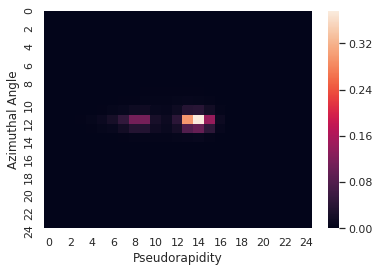

In [40]:
mean_signal_matrix = mean_signal.values
print(mean_signal_matrix.shape)
mean_signal_matrix = mean_signal_matrix.reshape((25,25))

print_heatmap(mean_signal_matrix)

We then add a last column, with the value of `1`. This last column classify this data as signal data. After creating the full dataset we will rename this column to _class_.

In [41]:
signal_data[625] = 1

In [42]:
signal_data.iloc[0:10,625]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: 625, dtype: int64

After preprocessing the _signal_ data, we will perform the same steps with the _background_ data.

In [43]:
!wget -c https://github.com/raphaelmcobe/jet-classification/raw/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt

--2020-02-20 17:04:49--  https://github.com/raphaelmcobe/jet-classification/raw/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo github.com (github.com)... 18.231.5.6
Conectando-se a github.com (github.com)|18.231.5.6|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 302 Found
Localização: https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt [redirecionando]
--2020-02-20 17:04:49--  https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.92.133
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|151.101.92.133|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 206 Partial Content
Tamanho: 91807548 (88M), 66857083 (64M) restantes [text/plain]
Salvando em: “background_PU0_13TeV_MJ-65-95_PTJ-250-300

In [44]:
backgroud_data = pd.read_table('background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', header=None, dtype=np.float32)
print(backgroud_data.shape)

(11298, 626)


In [45]:
backgroud_data.drop(625, axis=1, inplace=True)
print(backgroud_data.shape)

(11298, 625)


In [46]:
mean_background = backgroud_data.mean()
print(mean_background.iloc[1:10,])

1    0.000000e+00
2    0.000000e+00
3    8.339239e-08
4    0.000000e+00
5    1.226879e-06
6    9.698673e-07
7    3.696426e-06
8    8.896710e-06
9    5.325904e-06
dtype: float32


(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


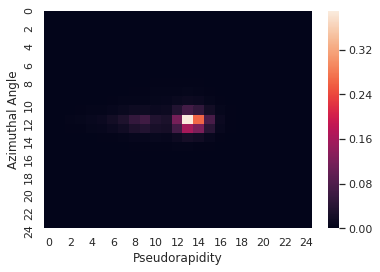

In [47]:
mean_background_matrix = mean_background.values
print(mean_background_matrix.shape)
mean_background_matrix = mean_background_matrix.reshape((25,25))

print_heatmap(mean_background_matrix)

We modify this data, to point out that this is the background data, by setting the last column to `0`.

In [48]:
backgroud_data[625] = 0

In [49]:
backgroud_data.iloc[0:10,625]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 625, dtype: int64

Now we concatenate the data and shuffle it in order to randomize its columns.

In [50]:
frames = [signal_data, backgroud_data]
full_data = pd.concat(frames)

In [51]:
full_data = full_data.sample(frac=1).reset_index(drop=True)
full_data.rename(columns={625:'class'}, inplace=True)

Now let's examine how our data looks like.

In [52]:
from IPython.core.display import display
with pd.option_context('display.max_rows', 200, 'display.max_columns', 15, 
                       'display.float_format', '{:.2f}'.format):
    display(full_data)

,0,1,2,3,4,5,6,...,619,620,621,622,623,624,class
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22591,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22592,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22593,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22594,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0


# Defining and Training the model

Split the full dataset into _test_ and _train_ data in a 70-30% rate.

In [114]:
train_data, test_data = train_test_split(full_data, test_size = 0.3)
print(train_data.shape)

print(test_data.shape)

(15817, 626)
(6779, 626)


The _Keras_ framework, in order to train its network must receive the dependent and independent variables in  separated tables.

In [115]:
X_train = train_data.iloc[:, :-1]
print(X_train.shape)
Y_train = train_data.iloc[:,-1:]
print(Y_train.shape)

(15817, 625)
(15817, 1)


In [116]:
X_test = test_data.iloc[:, :-1]
print(X_test.shape)
Y_test = test_data.iloc[:,-1:]
print(Y_test.shape)

(6779, 625)
(6779, 1)


We must convert the dependent variable to be a probability distribution of the possible outcomes, thus, a value of output `1` must become the probabilities `(0, 1)`. Conversely, a `0` outcome value must become the pair `(1, 0)`.

In [117]:
Y_train = to_categorical(Y_train.values, num_classes=2)

## Neural Network Architecture Definition

We defined a simple NN, with only two hidden layer.

In [118]:
dimof_input = X_train.shape[1]
model = Sequential()
model.add(Dense(units=400, activation='relu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=210, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=105, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=50, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=25, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=12, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=6, activation='elu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=2))
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
              metrics=["accuracy"])

After defining the NN architecture we train it using the `fit` method. We trained it for 50 epochs (backpropagation cycles). 

In [119]:
model.fit(X_train.values, Y_train, batch_size=150, epochs=350, verbose=1)

Train on 15817 samples
Epoch 1/350
15817/15817 [==============================] - 1s 68us/sample - loss: 0.1092 - accuracy: 0.6739
Epoch 2/350
15817/15817 [==============================] - 0s 29us/sample - loss: 0.0928 - accuracy: 0.7311
Epoch 3/350
15817/15817 [==============================] - 0s 28us/sample - loss: 0.0872 - accuracy: 0.7511
Epoch 4/350
15817/15817 [==============================] - 0s 28us/sample - loss: 0.0822 - accuracy: 0.7678
Epoch 5/350
15817/15817 [==============================] - 0s 29us/sample - loss: 0.0785 - accuracy: 0.7789
Epoch 6/350
15817/15817 [==============================] - 0s 28us/sample - loss: 0.0775 - accuracy: 0.7850
Epoch 7/350
15817/15817 [==============================] - 0s 28us/sample - loss: 0.0730 - accuracy: 0.7984
Epoch 8/350
15817/15817 [==============================] - 0s 28us/sample - loss: 0.0713 - accuracy: 0.8053
Epoch 9/350
15817/15817 [==============================] - 0s 28us/sample - loss: 0.0681 - accuracy: 0.8188
Epoch

15817/15817 [==============================] - 0s 30us/sample - loss: 0.0211 - accuracy: 0.9502
Epoch 77/350
15817/15817 [==============================] - 0s 29us/sample - loss: 0.0216 - accuracy: 0.9494
Epoch 78/350
15817/15817 [==============================] - 0s 29us/sample - loss: 0.0206 - accuracy: 0.9511
Epoch 79/350
15817/15817 [==============================] - 0s 29us/sample - loss: 0.0211 - accuracy: 0.9502
Epoch 80/350
15817/15817 [==============================] - 0s 30us/sample - loss: 0.0217 - accuracy: 0.9472
Epoch 81/350
15817/15817 [==============================] - 0s 29us/sample - loss: 0.0203 - accuracy: 0.9520
Epoch 82/350
15817/15817 [==============================] - 0s 29us/sample - loss: 0.0206 - accuracy: 0.9501
Epoch 83/350
15817/15817 [==============================] - 0s 29us/sample - loss: 0.0203 - accuracy: 0.9514
Epoch 84/350
15817/15817 [==============================] - 0s 29us/sample - loss: 0.0189 - accuracy: 0.9556
Epoch 85/350
15817/15817 [======

15817/15817 [==============================] - 1s 32us/sample - loss: 0.0099 - accuracy: 0.9779
Epoch 225/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0095 - accuracy: 0.9793
Epoch 226/350
15817/15817 [==============================] - 1s 32us/sample - loss: 0.0104 - accuracy: 0.9771
Epoch 227/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0102 - accuracy: 0.9769
Epoch 228/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0096 - accuracy: 0.9798
Epoch 229/350
15817/15817 [==============================] - 1s 33us/sample - loss: 0.0096 - accuracy: 0.9790
Epoch 230/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0110 - accuracy: 0.9757
Epoch 231/350
15817/15817 [==============================] - 0s 30us/sample - loss: 0.0103 - accuracy: 0.9783
Epoch 232/350
15817/15817 [==============================] - 0s 31us/sample - loss: 0.0096 - accuracy: 0.9793
Epoch 233/350
15817/1581

After training the model we need to evaluate it.

In [120]:
Y_test = to_categorical(Y_test.values, num_classes=2)

In [121]:
score = model.evaluate(X_test.values, Y_test, verbose=0)
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.12034152415205304, 0.728131]


Now let's take a look at the missclassified observations.

In [61]:
Y_test_predicted = model.predict(X_test.values, verbose=0)

In [62]:
Y_test_predicted

array([[-1.357203  ,  0.98958546],
       [ 0.6617522 ,  0.23518685],
       [ 0.981468  , -1.472672  ],
       ...,
       [ 1.0029294 , -2.2474194 ],
       [ 1.0318649 , -3.357037  ],
       [-1.4040315 ,  0.9924276 ]], dtype=float32)

Now we calculate the false negatives and also the false positives by comparing the true value with the predicted one.

In [63]:
Y_test_predicted_values = get_predicted_values(Y_test_predicted)
Y_test_values = get_predicted_values(Y_test)
print(Y_test_predicted_values[1:10])
print(Y_test_values[1:10])

false_positives = []
false_negatives = []
for i in range(len(Y_test_values)):
    if Y_test_values[i] == 0 and Y_test_predicted_values[i] == 1:
        false_positives.append(i)
    elif Y_test_values[i] == 1 and Y_test_predicted_values[i] == 0:
        false_negatives.append(i)
        
print("False Positive Rate: {:.2f}".format(len(false_positives)/len(Y_test_values)))
print("False Negative Rate: {:.2f}".format(len(false_negatives)/len(Y_test_values)))

[0, 0, 0, 1, 1, 0, 1, 0, 1]
[0, 1, 1, 1, 1, 0, 0, 0, 1]
False Positive Rate: 0.12
False Negative Rate: 0.15


And try to visualize the heatmaps for false positives and negatives. Firstly the false negatives, where the network was supposed to answer _Signal_, but instead, it answered _Background_.

[3, 11, 28, 37, 46, 53, 56, 57, 59]
(995, 625)
(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


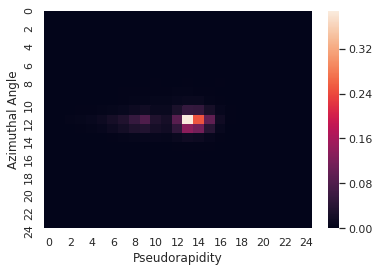

In [64]:
print(false_negatives[1:10])
false_negatives_values = X_test.iloc[false_negatives,]
print(false_negatives_values.shape)

mean_false_negatives = false_negatives_values.mean().values
print(mean_false_negatives.shape)
mean_false_negatives = mean_false_negatives.reshape((25,25))

print_heatmap(mean_false_negatives)

Then we examine the cases in which the network should have responded _Background_, but it answered _Signal_.

[32, 38, 47, 63, 65, 69, 71, 75, 77]
(820, 625)
(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


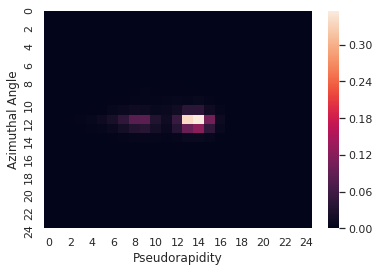

In [65]:
print(false_positives[1:10])
false_positives_values = X_test.iloc[false_positives,]
print(false_positives_values.shape)

mean_false_positives = false_positives_values.mean().values
print(mean_false_positives.shape)
mean_false_positives = mean_false_positives.reshape((25,25))

print_heatmap(mean_false_positives)

### Pipeline

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

#Classificadores Lineares
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

#Classificadores KNN
from sklearn.neighbors import KNeighborsClassifier

#Classificadores Naive Nayes
from sklearn.naive_bayes import MultinomialNB

#Classificadores Arvores de Decisão
from sklearn.tree import DecisionTreeClassifier

#SVM
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report

from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

from sklearn import linear_model
from scipy.special import expit

from sklearn.metrics import confusion_matrix
import scipy
from scipy.io import arff

import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.svm import SVC
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.externals import joblib

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut

In [95]:
# Construindo pipelines

pipe_knn = Pipeline([('scl', StandardScaler()), ('clf', KNeighborsClassifier())])
pipe_dt = Pipeline([('scl', StandardScaler()), ('clf', DecisionTreeClassifier())])



In [96]:
# Lista de pipelines a serem executados
pipelines = [ pipe_knn, pipe_dt]

# Dicionário para facilitar identificacao
pipe_dict = { 0: 'KNN', 1: 'Decision Tree'}

In [97]:
pipe_knn.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [98]:
pipe_dt.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [99]:
# Compara acurácia
for idx, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, Y_test)))

KNN pipeline test accuracy: 0.657
Decision Tree pipeline test accuracy: 0.645


In [100]:
# para cada modelo treinado obtem val score
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    # Descobre o melhor val.score e armazen em best_clf
    if val.score(X_test, Y_test) > best_acc:
        best_acc = val.score(X_test, Y_test)
        best_pipe = val
        best_clf = idx
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])

Classifier with best accuracy: KNN
